In [1]:
## Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import linregress

In [2]:
## Read files and data clean
def read_satellite_data(satellite):
    # --- Main Execution ---
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    df = df[df['veg_class'].isin([11, 12, 13, 14])]
    return df

In [3]:
## Read AVHRR data, effect size data, then combine
satellite = "avhrr" 
df = read_satellite_data(satellite)

eos_cols = [col for col in df.columns if 'eos' in col]
t_cols = [col for col in df.columns if 'annual_t' in col]
p_cols = [col for col in df.columns if 'annual_p' in col]

years = [str(y) for y in range(1982, 2017)]
cols = years
# df = df[[col for col in eos_cols + t_cols + p_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
t_cols_df = [col for col in df.columns if 'annual_t' in col]
df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
df.columns = df.columns.str.replace(r'/D*(/d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
df_climate = df[['annual_t', 'annual_p', 'latitude', 'longitude']]
# print(df_climate)
effect_size = pd.read_csv(f"../data/effect_size/avhrr/effect_size_ate.csv")
effect_size = pd.merge(effect_size, df_climate, on=['latitude', 'longitude'], how='inner')
# effect_size
effect_size_hot_dry = effect_size[(effect_size['annual_p'] < 0.9) & (effect_size['annual_t'] > 7.25)]
effect_size_cold_dry = effect_size[(effect_size['annual_p'] < 0.9) & (effect_size['annual_t'] < 7.25)]
effect_size_wet = effect_size[effect_size['annual_p'] > 0.9]

In [4]:
## Get the dominant driver at each temperature bin
def plot_strongest_effect_by_temp_bin(df, name):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    effect_columns = [
        'sos_es_w1',
        'spring_t_es_w1', 'summer_t_es_w1', 'autumn_t_es_w1',
        'spring_p_es_w1', 'summer_p_es_w1', 'autumn_p_es_w1',
        'spring_r_es_w1', 'summer_r_es_w1', 'autumn_r_es_w1'
    ]

    color_map = {
        'sos_es_w1': '#ff69b4',  # SOS in pink
        'spring_t_es_w1': '#e9967a',  # Temp spring - light red
        'summer_t_es_w1': '#e03c31',  # Temp summer - medium red
        'autumn_t_es_w1': '#8b1c13',  # Temp autumn - dark red
        'spring_p_es_w1': '#99c2ff',  # Prcp spring - light blue
        'summer_p_es_w1': '#0073e6',  # Prcp summer - medium blue
        'autumn_p_es_w1': '#004a99',  # Prcp autumn - dark blue
        'spring_r_es_w1': '#d8c3e2',  # Rad spring - light gray
        'summer_r_es_w1': '#a991c1',     # Rad summer - medium gray
        'autumn_r_es_w1': '#7a5fa0'   # Rad autumn - dark gray
    }

    label_map = {
        'sos_es_w1': 'SOS',
        'spring_t_es_w1': 'Spring T',
        'summer_t_es_w1': 'Summer T',
        'autumn_t_es_w1': 'Autumn T',
        'spring_p_es_w1': 'Spring P',
        'summer_p_es_w1': 'Summer P',
        'autumn_p_es_w1': 'Autumn P',
        'spring_r_es_w1': 'Spring SR',
        'summer_r_es_w1': 'Summer SR',
        'autumn_r_es_w1': 'Autumn SR'
    }

    # Filter to valid temperature range and drop missing
    df = df[(df['annual_t'] >= -5) & (df['annual_t'] <= 15)].copy()
    df = df.dropna(subset=['annual_t'])

    # Define 1°C bins and assign midpoints
    bin_edges = np.arange(np.floor(df['annual_t'].min()), np.ceil(df['annual_t'].max()) + 1, 1)
    df['temp_bin'] = pd.cut(df['annual_t'], bins=bin_edges, right=False)
    df['bin_center'] = df['temp_bin'].apply(lambda x: x.left + 0.5)

    # Filter bins with at least 5 observations
    counts = df['temp_bin'].value_counts()
    valid_bins = counts[counts >= 5].index
    df = df[df['temp_bin'].isin(valid_bins)]

    # Group by bin center
    grouped_mean = df.groupby('bin_center', observed=True)[effect_columns].mean()
    grouped_std = df.groupby('bin_center', observed=True)[effect_columns].std()
    bin_sizes = df.groupby('bin_center', observed=True).size()
    grouped_se = grouped_std.divide(np.sqrt(bin_sizes), axis=0)

    # Find strongest effect per bin
    strongest_vars = grouped_mean.abs().idxmax(axis=1)
    strongest_vals = grouped_mean.to_numpy()[np.arange(len(grouped_mean)),
                                              grouped_mean.columns.get_indexer(strongest_vars)]
    strongest_ses = grouped_se.to_numpy()[np.arange(len(grouped_se)),
                                          grouped_se.columns.get_indexer(strongest_vars)]

    # Create DataFrame for plotting and drop bins where dominant var is NaN
    plot_df = pd.DataFrame({
        'bin_center': grouped_mean.index,
        'var': strongest_vars.values,
        'effect_size': strongest_vals,
        'se': strongest_ses
    }).dropna(subset=['var'])


    # Plot
    fig = plt.figure(figsize=(8, 6))
    for var in plot_df['var'].unique():
        subset = plot_df[plot_df['var'] == var]
        plt.bar(
            subset['bin_center'], subset['effect_size'],
            yerr=2 * subset['se'], capsize=4,
            width=0.7, label=label_map[var], color=color_map[var]
        )
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(-5, 15)
    plt.ylim(-0.6, 0.5)
    plt.xticks([-5, 0, 5, 10, 15])
    plt.text(- 2, 0.4, f'{name}',
            color='black', fontsize=14, ha='center')
    plt.axhline(0, color='black', linewidth=1)
    plt.xlabel("MAT (°C)", fontsize=14)
    plt.ylabel("Effect Size", fontsize=14)
    # plt.title(f"Strongest Variable Effect by 1°C MAT Bin ({name})")
    plt.legend(loc='lower left', frameon=False, ncol=2, fontsize=12)
    plt.tight_layout()
    plt.show()

    return fig


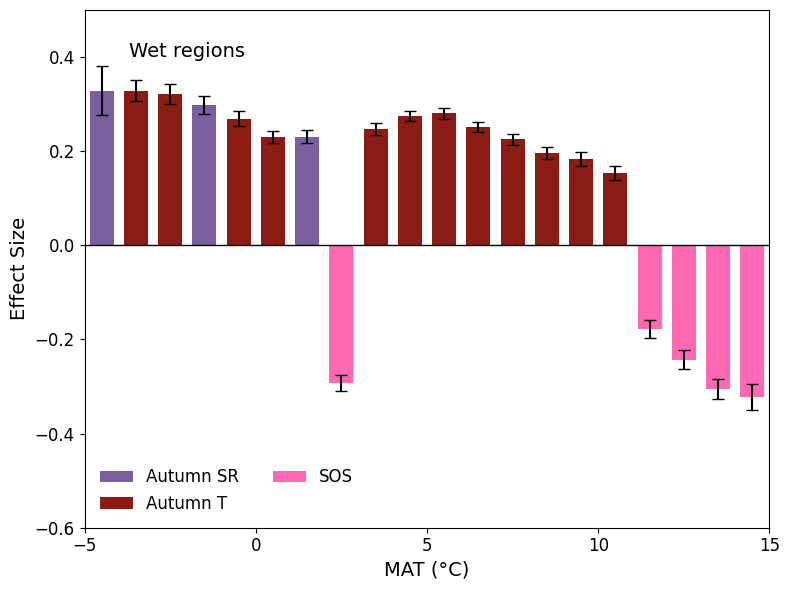

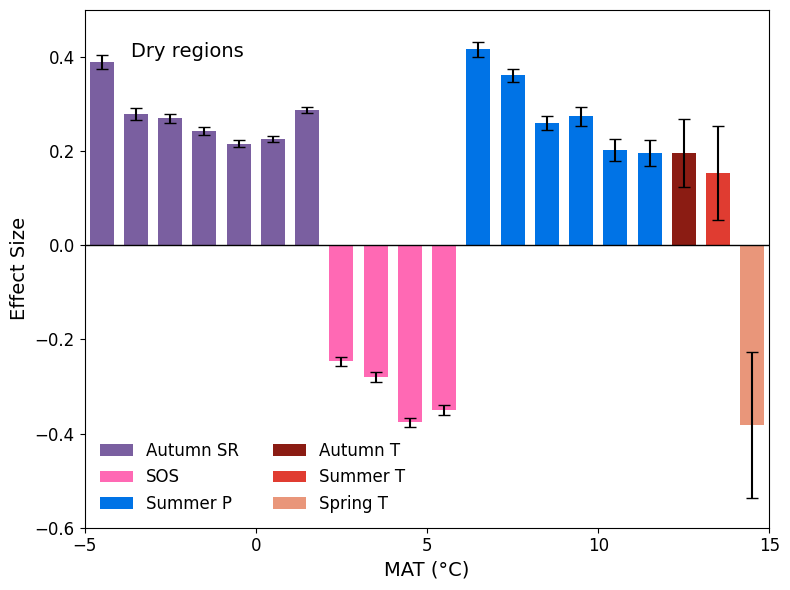

In [6]:
fig = plot_strongest_effect_by_temp_bin(effect_size_wet, "Wet regions")
fig.savefig("../results/si_figures/si_fig10/des_t_bin_wet.png", dpi=300, bbox_inches='tight')

effect_size_low_prcp = pd.concat([effect_size_cold_dry, effect_size_hot_dry], axis=0, ignore_index=True)
fig = plot_strongest_effect_by_temp_bin(effect_size_low_prcp, "Dry regions")
fig.savefig("../results/si_figures/si_fig10/des_t_bin_dry.png", dpi=300, bbox_inches='tight')
